# Predicting the chance of startup success

## Table of Contents

[Take a Peek at the Dataset](#t1)

[Which metric should we use?](#t4)

[Train a model using Autogluon](#t2)

[Use Cleanlab filter to find outliners](#t3)

[Use Cleanlab to train better models](#t5)

[How does Cleanlab help to improve performance](#t6)

[Reference](#t7)

In [63]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None
pd.set_option("display.max_colwidth", None)
plt.style.use('fivethirtyeight')


<a id='t1'></a>
## Take a peek at the dataset

In [64]:
train_path = '../data/crunchbase_train.csv'
test_path = '../data/crunchbase_test.csv'
train_pd = pd.read_csv(train_path)
test_pd = pd.read_csv(test_path)

In [65]:
train_pd.head()

,name,market,funding_total_usd,country_code,region,city,funding_rounds,founded_month,founded_quarter,founded_year,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,status_binary,total_investment
0,1000memories,Curated Web,"25,35,000",USA,SF Bay Area,San Francisco,2.0,7.0,3.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.630137,1,2535000.0
1,10BestThings,Curated Web,"50,000",USA,Cleveland,Cleveland,1.0,4.0,2.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0,50000.0
2,1bib,Curated Web,-,CHN,Guangzhou,Guangzhou,1.0,1.0,1.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.10137,2.101370,0,0.0
3,1Cast,Other,-,USA,Seattle,Kirkland,1.0,6.0,2.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.20000,2.200000,0,0.0
4,1DayMakeover,E-Commerce,"50,000",USA,"Orange County, California",Santa Ana,1.0,6.0,2.0,2008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0,50000.0


In [66]:
train_pd.columns

Index(['name', 'market', 'funding_total_usd', 'country_code', 'region', 'city',
       'funding_rounds', 'founded_month', 'founded_quarter', 'founded_year',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'age_first_funding', 'age_last_funding', 'status_binary',
       'total_investment'],
      dtype='object')

### Acquired Vs Closed Ratio by Founded Year

In [67]:
merge_pd = pd.concat([train_pd, test_pd], axis= 0)
acquired_counts = pd.DataFrame(merge_pd[merge_pd.status_binary == 1].groupby(['founded_year'])['name'].count())
closed_counts = pd.DataFrame(merge_pd[merge_pd.status_binary == 0].groupby(['founded_year'])['name'].count())

In [68]:
total_pd = pd.merge(left = acquired_counts, right = closed_counts, left_on='founded_year', right_on='founded_year')
total_pd.columns = ['acquired', 'closed']
total_pd['ratio'] = total_pd.acquired/total_pd.closed

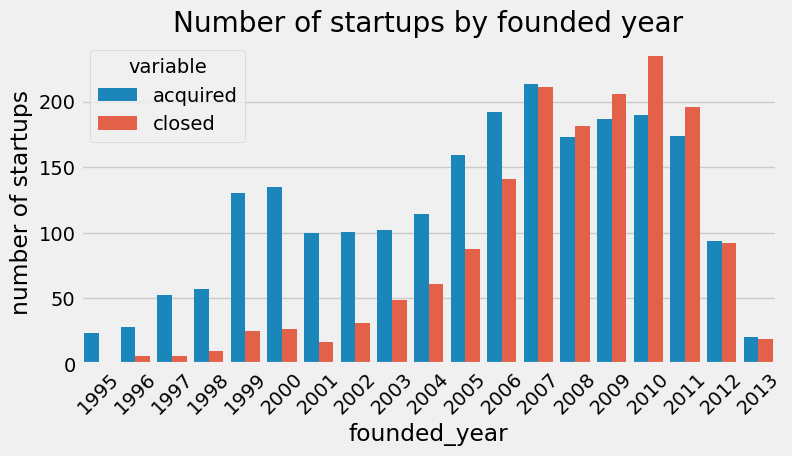

In [69]:
melt_pd = total_pd.reset_index().melt(id_vars='founded_year')
bar_1 = melt_pd[melt_pd.variable.isin(['acquired', 'closed'])]
bar_1['founded_year'] = bar_1['founded_year'].astype('int')
plt.figure(figsize=(8, 4))
sns.barplot(data=bar_1, x='founded_year', y='value', hue='variable')
plt.ylabel('number of startups')
plt.xticks(rotation=45)
plt.title('Number of startups by founded year');

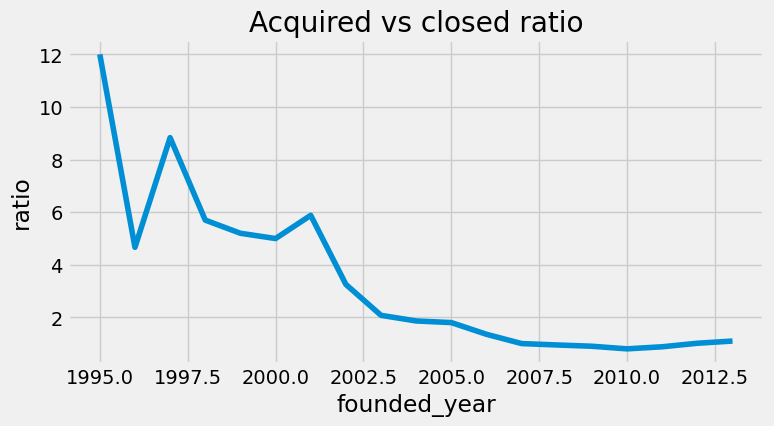

In [70]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=total_pd, x=total_pd.index, y=total_pd.ratio)
plt.ylabel('ratio')
plt.title('Acquired vs closed ratio');

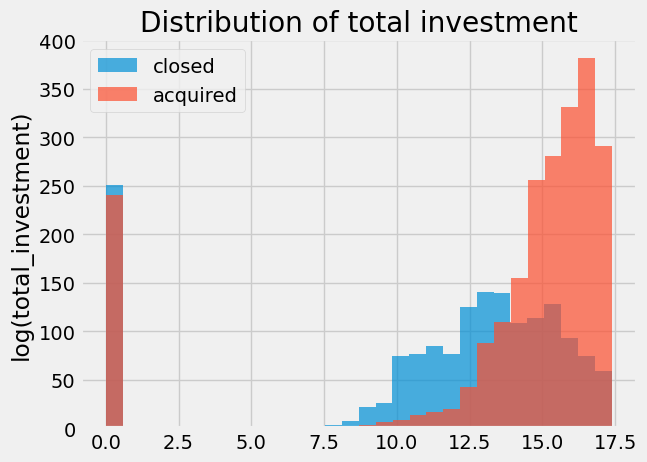

In [71]:
plt.hist(np.log1p(merge_pd[merge_pd.status_binary==0]['total_investment']), bins=30, alpha=.7, label='closed')
plt.hist(np.log1p(merge_pd[merge_pd.status_binary==1]['total_investment']), bins=30, alpha=.7, label='acquired')
plt.legend()
plt.ylabel('log(total_investment)')
plt.title('Distribution of total investment');

<a id='t4'></a>
## Which metric should we use?

- Conventionally, F1 (a combination of precisiona and recall) is used for classification tasks

- In this case, we choose to focus on different metrics based on the clients we serve

- **For investors and buyers** we focus on **precision** because the cost of **false positive** is high -- imagine if they make a proposal to acquire but end up failing at it, it will cost them billions in lawsuit; this is exactly what's happening on Elon Musk's twitter deal!

- **For startup founders** we focus on **recall** because it costs them lots of effort if the model gives **false negative** prediction. They might easily give up on their amibitious goal even though it can be successful in the future!

<a id='t2'></a>

## Train an ML model using Autogluon

In [72]:
from autogluon.tabular import TabularPredictor


In [73]:
estimator = TabularPredictor(label='status_binary', verbosity=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20220921_191809/"


In [74]:
## drop some unnessary columns
drop_cols = [
    'name', 'country_code', 'region', 'city',
    'post_ipo_equity', 'post_ipo_debt',
    'round_G', 'round_H','age_last_funding', 'funding_total_usd'
]
X_train = train_pd.drop(drop_cols, axis=1)
X_test = test_pd.drop(drop_cols, axis=1)
hyperparam = {'RF':{}, 'GBM':{}, 'XGB': {}}

In [75]:
estimator.fit(train_data=X_train, tuning_data=X_test, hyperparameters=hyperparam)

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'


In [76]:
estimator.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.738693       0.010902  7.539481                0.001120           0.078768            2       True          4
1             LightGBM   0.737018       0.003838  5.678370                0.003838           5.678370            1       True          1
2              XGBoost   0.718593       0.005944  1.782343                0.005944           1.782343            1       True          3
3         RandomForest   0.693467       0.046523  0.370984                0.046523           0.370984            1       True          2


,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.738693,0.010902,7.539481,0.001120,0.078768,2,True,4
1,LightGBM,0.737018,0.003838,5.678370,0.003838,5.678370,1,True,1
2,XGBoost,0.718593,0.005944,1.782343,0.005944,1.782343,1,True,3
3,RandomForest,0.693467,0.046523,0.370984,0.046523,0.370984,1,True,2


### Computer Overall Accuracies and Confusion Matrix

In [77]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score

In [78]:
# Get labels.
y_test = X_test["status_binary"]
# Drop label col for prediction.
test_data_nolab = X_test.drop("status_binary", axis=1)
# Make prediction and evaluate performance
y_pred = estimator.predict(test_data_nolab)
perf = estimator.evaluate_predictions(
    y_true=y_test, y_pred=y_pred, auxiliary_metrics=True
)

def eval_model_perf(perf, y_tes, y_pred, plot=False, results=False):
    """
    evaluating on accuracy, precision, recall
    plot confusion matrix
    """
    
    base_acc = perf["accuracy"]
    matrix = confusion_matrix(y_test, y_pred)
    # Per-class accuracies are important!
    class_acc = matrix.diagonal() / matrix.sum(axis=1)
    class_acc_str = [f"{acc:0.1%}" for acc in class_acc]

    print(f"Accuracy: {base_acc:.1%}")
    print(class_acc_str)

    preci = precision_score(y_test, y_pred)
    reca = recall_score(y_test, y_pred)
    print(f"Precision: {preci: .3f}")
    print(f"Recall: {reca: .3f}")
    
    if plot:
        columns=[ 'Closed', 'Acquired']
        df_cm = pd.DataFrame(matrix, index=columns, columns=columns)
        plt.figure(figsize=(3,3))
        ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    if results:
        return (preci, reca, base_acc)

Accuracy: 73.9%
['78.2%', '69.2%']
Precision:  0.749
Recall:  0.692


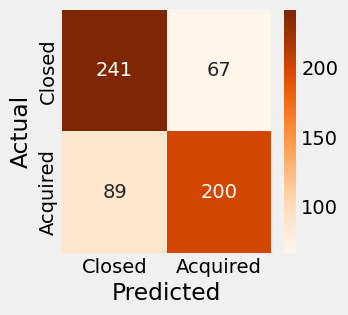

In [79]:
origin_prec, origin_reca, origin_accu= eval_model_perf(perf, y_test, y_pred, plot=True, results=True)

<a id='t3'></a>

## Using `find_label_issues` from `cleanlab.filter`

In [80]:
del estimator

In [81]:
from cleanlab.filter import find_label_issues

In [82]:
def get_pred_probs(X_train, X_test, label='status_binary'):
    """Uses cross-validation to obtain out-of-sample predicted probabilities
    for our entire dataset"""

    hyperparameters = {
        'RF':{},
        'GBM':{},
        'XGB':{}
    }
    num_examples, num_classes = X_train.shape[0], len(X_train[label].value_counts())
    skf = StratifiedKFold()
    skf_splits = [
        [train_index, test_index]
        for train_index, test_index in skf.split(X=X_train, y=X_train[label])
    ]
    pred_probs = pd.DataFrame(
        np.zeros((num_examples, num_classes)),
        columns=['Closed', 'Acquired'],
    )

    # Iterate through cross-validation folds
    for split_num, split in enumerate(skf_splits):
        train_index, val_index = split
        train_data_subset = X_train.iloc[train_index]
        validation_data = X_train.iloc[val_index]
        predictor = TabularPredictor(label=label, verbosity=0)
        predictor.fit(
            train_data_subset,
            tuning_data=validation_data,
            hyperparameters=hyperparameters,
        )
        pred_probs_fold = predictor.predict_proba(validation_data, as_pandas=True)
        pred_probs.iloc[val_index] = pred_probs_fold
        del pred_probs_fold
    return pred_probs.values

# Out-of-sample predicted probabilities
pred_probs = get_pred_probs(X_train, X_test)

In [83]:
ordered_label_issues = find_label_issues(
    labels=X_train.status_binary.values,
    pred_probs=pred_probs,
    filter_by="confident_learning",
    return_indices_ranked_by="self_confidence",
)
percentage = len(ordered_label_issues)*100/train_pd.shape[0]
print(f"percentage of outliners identified : {percentage:.3f}%")
print(f"10 most outstanding outliers identified: ")
positive_idx = [i for i in ordered_label_issues if train_pd.status_binary[i] == 1]
train_pd.iloc[positive_idx[:10], :]

percentage of outliners identified : 16.687%
10 most outstanding outliers identified: 


,name,market,funding_total_usd,country_code,region,city,funding_rounds,founded_month,founded_quarter,founded_year,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,status_binary,total_investment
1611,Mad Mimi,Curated Web,"1,10,000",USA,New York City,Brooklyn,1.0,4.0,2.0,2008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-1.005479,1,110000.0
1444,Keepstream,Social Media,"20,000",USA,Austin,Austin,1.0,1.0,1.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.328767,0.328767,1,20000.0
3184,Yostro,Other,"38,880",CAN,Ottawa,Ottawa,1.0,10.0,4.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.052055,0.052055,1,38880.0
2923,TwitJump,Other,"1,50,000",USA,Salt Lake City,Salt Lake City,1.0,5.0,2.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.043836,1,150000.0
1722,MobFox,Advertising,"69,830",AUT,Vienna,Vienna,1.0,1.0,1.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.079452,0.079452,1,69830.0
715,Desura,Other,"1,00,000",AUS,AUS - Other,Cottesloe,1.0,7.0,3.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.627397,0.627397,1,100000.0
2653,StartupDigest,Other,"2,00,000",USA,Seattle,Seattle,1.0,11.0,4.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.309589,1.309589,1,200000.0
3173,YelloYello,Social Media,"65,850",NLD,The Hague,Rijswijk,1.0,9.0,3.0,2007.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.665753,1,65850.0
1076,GigPark,Social Media,"2,00,000",CAN,Toronto,Toronto,1.0,1.0,1.0,2007.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1,200000.0
1198,HipChat,Other,"1,00,000",USA,SF Bay Area,San Francisco,1.0,9.0,3.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.939726,0.939726,1,100000.0


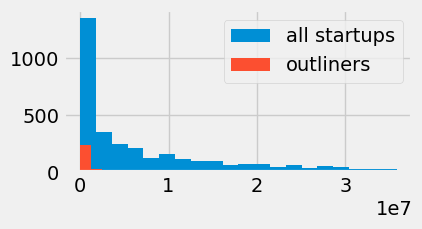

In [84]:
plt.figure(figsize=(4,2))
train_pd.total_investment.hist(bins=20, label='all startups')
train_pd.iloc[positive_idx, :].total_investment.hist(bins=20, label='outliners')
plt.legend();

<a id='t5'></a>

## Train better model by removing outliers

In [85]:
len(ordered_label_issues)
#X_train.shape[0]*.1

543

Accuracy: 74.7%
['85.4%', '63.3%']
Precision:  0.803
Recall:  0.633


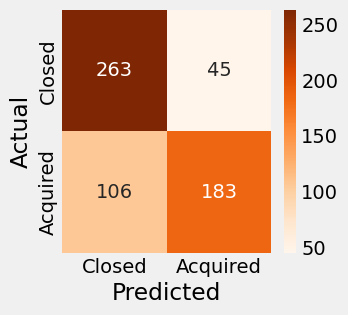

In [86]:
# Remove error-prone labels from training set.
clean_train_data = X_train.drop(ordered_label_issues)

# Train the models with cleaned data (we are actually training with LESS data!)
predictor = TabularPredictor(label="status_binary", verbosity=0)
predictor.fit(clean_train_data, tuning_data=X_test, hyperparameters=hyperparam)

# Test model
y_true = X_test["status_binary"]
test_data = X_test.drop("status_binary", axis=1)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(
    y_true=y_true, y_pred=y_pred, auxiliary_metrics=True
)
new_prec, new_reca, new_accu= eval_model_perf(perf, y_true, y_pred, plot=True, results=True)

In [87]:
prec_list = []
drop_label_numbers = []
recall_list = []
accu_list = []
for i in range(10, len(ordered_label_issues), 20):
    # Remove error-prone labels from training set.
    clean_train_data = X_train.drop(ordered_label_issues[:i])
    #print(f"drop labels: {i}")
    # Train the models with cleaned data (we are actually training with LESS data!)
    predictor = TabularPredictor(label="status_binary", verbosity=0)
    predictor.fit(clean_train_data, tuning_data=X_test, hyperparameters=hyperparam)
    
    # Test model
    y_true = X_test["status_binary"]
    test_data = X_test.drop("status_binary", axis=1)
    y_pred = predictor.predict(test_data)
    perf = predictor.evaluate_predictions(
        y_true=y_true, y_pred=y_pred, auxiliary_metrics=True
    )
    prec, reca, accu = eval_model_perf(perf, y_true, y_pred, results=True)
    prec_list.append(prec)
    recall_list.append(reca)
    drop_label_numbers.append(i)
    accu_list.append(accu)

Accuracy: 73.5%
['85.4%', '60.9%']
Precision:  0.796
Recall:  0.609
Accuracy: 73.9%
['83.4%', '63.7%']
Precision:  0.783
Recall:  0.637
Accuracy: 74.4%
['85.7%', '62.3%']
Precision:  0.804
Recall:  0.623
Accuracy: 74.2%
['80.5%', '67.5%']
Precision:  0.765
Recall:  0.675
Accuracy: 74.0%
['74.7%', '73.4%']
Precision:  0.731
Recall:  0.734
Accuracy: 73.4%
['82.1%', '64.0%']
Precision:  0.771
Recall:  0.640
Accuracy: 73.5%
['84.1%', '62.3%']
Precision:  0.786
Recall:  0.623
Accuracy: 74.4%
['85.1%', '63.0%']
Precision:  0.798
Recall:  0.630
Accuracy: 73.4%
['85.4%', '60.6%']
Precision:  0.795
Recall:  0.606
Accuracy: 73.2%
['71.4%', '75.1%']
Precision:  0.711
Recall:  0.751
Accuracy: 74.0%
['83.4%', '64.0%']
Precision:  0.784
Recall:  0.640
Accuracy: 73.5%
['85.1%', '61.2%']
Precision:  0.794
Recall:  0.612
Accuracy: 73.5%
['75.0%', '72.0%']
Precision:  0.730
Recall:  0.720
Accuracy: 74.9%
['72.1%', '77.9%']
Precision:  0.723
Recall:  0.779
Accuracy: 75.4%
['76.3%', '74.4%']
Precision:  0

In [88]:
drop_label_numbers.append(len(ordered_label_issues))
prec_list.append(new_prec)
recall_list.append(new_reca)
accu_list.append(new_accu)

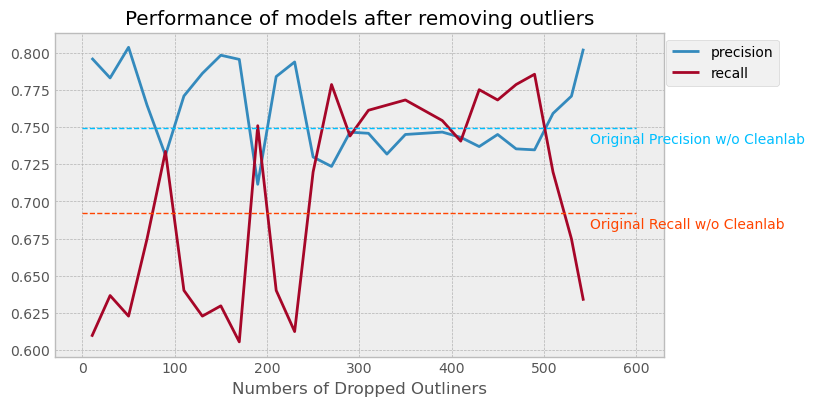

In [153]:
plt.figure(figsize=(7, 4))
plt.plot(drop_label_numbers, prec_list, label='precision')
plt.plot(drop_label_numbers, recall_list, label='recall')
#plt.plot(drop_label_numbers, accu_list, label='accuracy')

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.xlabel('Numbers of Dropped Outliners')
plt.hlines(y=origin_prec, xmin=0, xmax=600, linestyles='--', color='deepskyblue', linewidth=1)
plt.hlines(y=origin_reca, xmin=0, xmax=600, linestyles='--', color='orangered', linewidth=1)
#plt.hlines(y=origin_accu, xmin=0, xmax=600, linestyles='--', color='black', linewidth=1)
#plt.text(500, origin_accu-0.003, 'original_accuracy', **style)
style = dict(size=10, color='gray')
plt.text(550, 0.739, 'Original Precision w/o Cleanlab', size=10, color='deepskyblue')
plt.text(550, 0.682, 'Original Recall w/o Cleanlab', size=10, color='orangered')
plt.title('Performance of models after removing outliers');

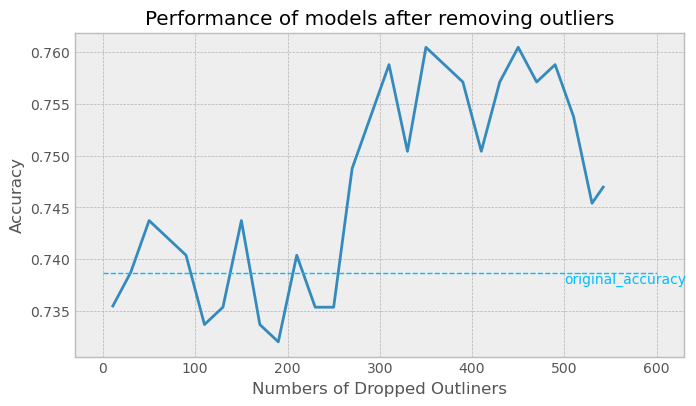

In [152]:
plt.figure(figsize=(7, 4))
plt.plot(drop_label_numbers, accu_list, label='accuracy')
plt.hlines(y=origin_accu, xmin=0, xmax=600, linestyles='--', color='deepskyblue', linewidth=1)
plt.text(500, origin_accu-0.001, 'original_accuracy', size=10, color='deepskyblue')
plt.xlabel('Numbers of Dropped Outliners')
plt.title('Performance of models after removing outliers')
plt.ylabel('Accuracy');

In [130]:
perf_pd = pd.DataFrame({'numbers': drop_label_numbers, 'precision': prec_list, 'recall': recall_list,
                        'accuracy': accu_list})

In [133]:
perf_pd['precision_changed'] = (perf_pd.precision-origin_prec)*100/origin_prec
perf_pd['recall_changed'] =( perf_pd.recall-origin_reca)*100/origin_reca
perf_pd['accuracy_changed'] = (perf_pd.accuracy-origin_accu)*100/origin_accu

In [149]:
plt.style.use('bmh')

In [158]:
perf_pd_pos = perf_pd[(perf_pd.precision_changed > 0 )& (perf_pd.recall_changed > 0) & (perf_pd.accuracy_changed >0)]

In [160]:
perf_pd_pos

,numbers,precision,recall,accuracy,precision_changed,recall_changed,accuracy_changed
25,510,0.759124,0.719723,0.753769,1.343066,4.0,2.040816


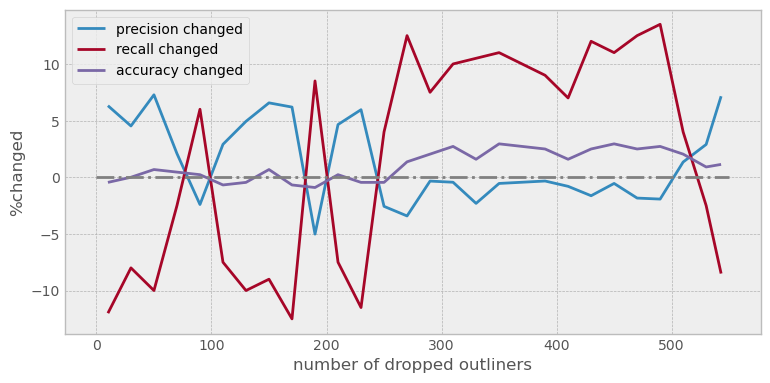

In [166]:
plt.figure(figsize=(8, 4))
plt.plot(perf_pd.numbers, perf_pd.precision_changed, label='precision changed')
plt.plot(perf_pd.numbers, perf_pd.recall_changed, label='recall changed')
plt.plot(perf_pd.numbers, perf_pd.accuracy_changed, label='accuracy changed')
plt.hlines(xmin=0,xmax=550,y=0, linestyles='-.', color='grey')
plt.ylabel('%changed')
plt.xlabel('number of dropped outliners')
plt.legend();

### Only removing negative outliners


Accuracy: 71.5%
['89.0%', '52.9%']
Precision:  0.818
Recall:  0.529


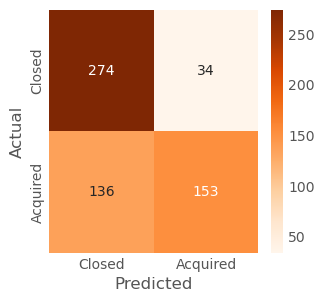

In [155]:
negative_idx = [i for i in ordered_label_issues if i not in positive_idx]
clean_train_data = X_train.drop(negative_idx)

# Train the models with cleaned data (we are actually training with LESS data!)
predictor = TabularPredictor(label="status_binary", verbosity=0, eval_metric="precision")
predictor.fit(clean_train_data, tuning_data=X_test, hyperparameters=hyperparam)

# Test model
y_true = X_test["status_binary"]
test_data = X_test.drop("status_binary", axis=1)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(
    y_true=y_true, y_pred=y_pred, auxiliary_metrics=True
)
eval_model_perf(perf, y_true, y_pred, plot=True)

### Only removing positive outliners

Accuracy: 70.7%
['93.8%', '46.0%']
Precision:  0.875
Recall:  0.460


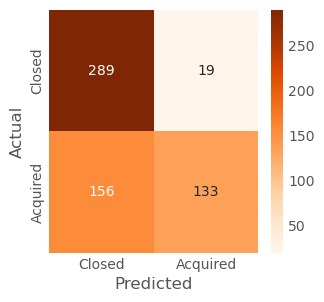

In [154]:

# Remove error-prone labels from training set.
clean_train_data = X_train.drop(positive_idx)

# Train the models with cleaned data (we are actually training with LESS data!)
predictor = TabularPredictor(label="status_binary", verbosity=0, eval_metric="precision")
predictor.fit(clean_train_data, tuning_data=X_test, hyperparameters=hyperparam)

# Test model
y_true = X_test["status_binary"]
test_data = X_test.drop("status_binary", axis=1)
y_pred = predictor.predict(test_data)
perf = predictor.evaluate_predictions(
    y_true=y_true, y_pred=y_pred, auxiliary_metrics=True
)
eval_model_perf(perf, y_true, y_pred, plot=True)

In [156]:
perf_pd

,numbers,precision,recall,accuracy,precision_changed,recall_changed,accuracy_changed
0,10,0.796380,0.608997,0.735343,6.316742,-12.0,-0.453515
1,30,0.782979,0.636678,0.738693,4.527660,-8.0,0.000000
2,50,0.803571,0.622837,0.743719,7.276786,-10.0,0.680272
3,70,0.764706,0.674740,0.742044,2.088235,-2.5,0.453515
4,90,0.731034,0.733564,0.740369,-2.406897,6.0,0.226757
5,110,0.770833,0.640138,0.733668,2.906250,-7.5,-0.680272
6,130,0.786026,0.622837,0.735343,4.934498,-10.0,-0.453515
7,150,0.798246,0.629758,0.743719,6.565789,-9.0,0.680272
8,170,0.795455,0.605536,0.733668,6.193182,-12.5,-0.680272
9,190,0.711475,0.750865,0.731993,-5.018033,8.5,-0.907029


<a id='t6'></a>

## How does CleanLab help to improve model performance?

Looking at the results above, `CleanLab` is able to **increase both precision and recall** as follows

- Drop the top 94% outliers identified by  `cleanlab`
    * Precision: 0.759 <font color='#00cc66'>+1.3%</font>
    * Recall: 0.720 <font color='#00cc66'>+4%</font>
    * Accuracy: 0.754 <font color='#00cc66'>+2%</font>
 

Hot take: Elon's team should try to improve the precision of their model for the next company acquisition...